In [2]:
import os

dataset_path = r"C:\Users\bhuva\OneDrive\Desktop\Muscle Dystrophy\torgo_data\data.csv"  # Replace with the actual path
for root, dirs, files in os.walk(dataset_path):
    print(f"📂 Folder: {root}")
    for file in files[:5]:  # Display first 5 files in each folder
        print(f"  📄 {file}")


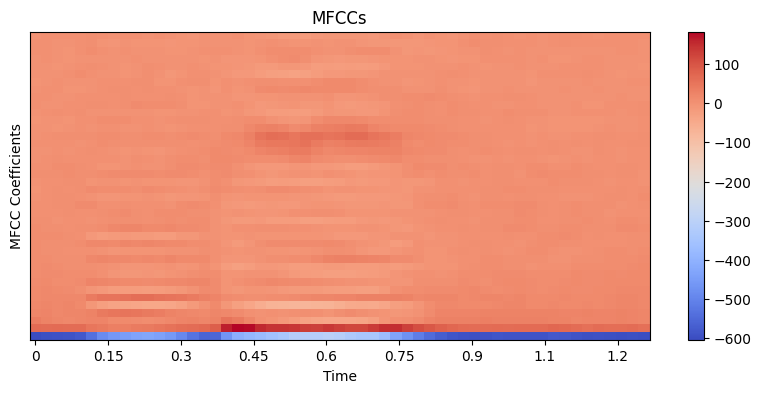

In [3]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Replace with an actual audio file path from your dataset
audio_file = r"C:\Users\bhuva\OneDrive\Desktop\Muscle Dystrophy\torgo_data\dysarthria_female\F01_Session1_0039.wav"

# Load audio
y, sr = librosa.load(audio_file, sr=22050)  # Default sampling rate

# Extract MFCCs
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)  # 40 MFCC features

# Plot the MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, sr=sr, x_axis="time")
plt.colorbar()
plt.title("MFCCs")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.show()


In [4]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm

# Function to extract MFCC features from an audio file
def extract_features(file_path, n_mfcc=40):
    y, sr = librosa.load(file_path, sr=22050)  # Load audio
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  # Extract MFCCs
    return np.mean(mfccs, axis=1)  # Take the mean across time

# Define dataset path
dataset_path = r"C:\Users\bhuva\OneDrive\Desktop\Muscle Dystrophy\torgo_data" # Update this path

# Collect data
data = []
labels = []

# Loop through each class (severity level)
for severity_level in os.listdir(dataset_path):  
    severity_folder = os.path.join(dataset_path, severity_level)
    
    if os.path.isdir(severity_folder):  # Ensure it's a folder
        for file in tqdm(os.listdir(severity_folder), desc=f"Processing {severity_level}"):
            file_path = os.path.join(severity_folder, file)
            
            try:
                features = extract_features(file_path)
                data.append(features)
                labels.append(severity_level)  # Store the severity level
            except Exception as e:
                print(f"Error processing {file}: {e}")

# Convert to a Pandas DataFrame
df = pd.DataFrame(data)
df["label"] = labels

# Save the extracted features
df.to_csv("mfcc_features.csv", index=False)
print("Feature extraction complete. Saved to 'mfcc_features.csv'.")


Processing dysarthria_female:   3%|█▌                                                 | 15/484 [00:00<00:06, 73.24it/s]C:\Users\bhuva\AppData\Local\Temp\ipykernel_2972\2669515239.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=22050)  # Load audio
C:\Users\bhuva\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processing dysarthria_female:   5%|██▍                                                | 23/484 [00:00<00:06, 68.07it/s]

Error processing F01_Session1_0068.wav: 


Processing dysarthria_male:  96%|█████████████████████████████████████████████████▊  | 479/500 [00:12<00:00, 34.74it/s]C:\Users\bhuva\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=946
  warnings.warn(
Processing dysarthria_male:  97%|██████████████████████████████████████████████████▋ | 487/500 [00:12<00:00, 35.11it/s]C:\Users\bhuva\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=581
  warnings.warn(
C:\Users\bhuva\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=209
  warnings.warn(
C:\Users\bhuva\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=185
  warnings.warn(
C:\Users\b

Feature extraction complete. Saved to 'mfcc_features.csv'.


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load extracted features
df = pd.read_csv("mfcc_features.csv")

# Separate features and labels
X = df.iloc[:, :-1].values  # All columns except last (features)
y = df["label"].values       # Last column (labels)

# Encode labels (convert text to numbers)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Print dataset shapes
print(f"Training data shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Labels: {y_test.shape}")

# Save encoded labels for later use
np.save("label_encoder_classes.npy", label_encoder.classes_)
print("Label encoding complete and saved.")


Training data shape: (1586, 40), Labels: (1586,)
Testing data shape: (397, 40), Labels: (397,)
Label encoding complete and saved.


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam

# Define model architecture
model = Sequential([
    Reshape((40, 1), input_shape=(40,)),  # Reshape input for CNN

    # CNN Layers
    Conv1D(filters=64, kernel_size=3, activation="relu"),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=128, kernel_size=3, activation="relu"),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    # LSTM Layer
    LSTM(64, return_sequences=False),

    # Fully Connected Layers
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.3),

    # Output Layer
    Dense(len(np.unique(y_train)), activation="softmax")  # Adjust for number of classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Print model summary
model.summary()


C:\Users\bhuva\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 40, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 38, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 38, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 19, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 17, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 17, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,972 (359.27 KB)

 Trainable params: 91,588 (357.77 KB)

 Non-trainable params: 384 (1.50 KB)

In [7]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,  # Adjust epochs based on performance
    batch_size=32,
    verbose=1
)

# Save the trained model
model.save("muscle_dystrophy_model.h5")
print("Model training complete and saved as 'muscle_dystrophy_model.h5'.")


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.4966 - loss: 1.1240 - val_accuracy: 0.5441 - val_loss: 1.1302
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7619 - loss: 0.6016 - val_accuracy: 0.5668 - val_loss: 0.9099
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8243 - loss: 0.4407 - val_accuracy: 0.8010 - val_loss: 0.5314
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8775 - loss: 0.3335 - val_accuracy: 0.8237 - val_loss: 0.4809
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9400 - loss: 0.1730 - val_accuracy: 0.7909 - val_loss: 0.5073
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9252 - loss: 0.2163 - val_accuracy: 0.9093 - val_loss: 0.2738
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9718 - loss: 0.1096 - val_accuracy: 0.8967 - val_loss: 0.3282
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9451 - loss: 0.1320 - val_accuracy: 0.9093 - v

Model training complete and saved as 'muscle_dystrophy_model.h5'.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9445 - loss: 0.2721
Test Accuracy: 94.46%
Test Loss: 0.3044
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92        97
           1       0.98      0.96      0.97        98
           2       0.90      0.94      0.92       101
           3       0.96      0.97      0.97       101

    accuracy                           0.94       397
   macro avg       0.95      0.94      0.94       397
weighted avg       0.95      0.94      0.94       397



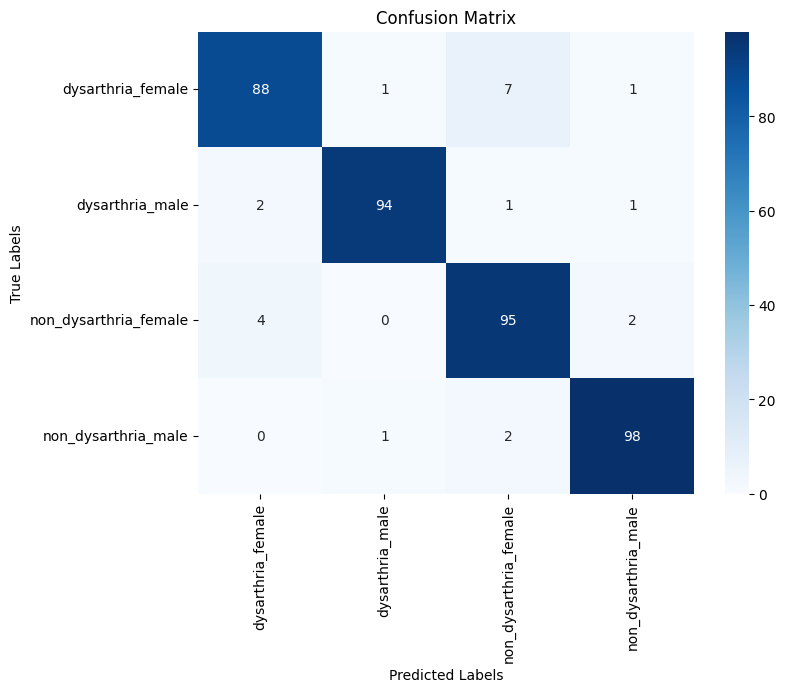

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Generate predictions
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [9]:
import librosa
import numpy as np

# Function to preprocess and extract MFCC from a new audio file
def preprocess_audio(file_path):
    y, sr = librosa.load(file_path, sr=22050)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return np.mean(mfccs, axis=1)

# Load the trained model
model = tf.keras.models.load_model("muscle_dystrophy_model.h5")

# Predict for a new audio file
new_audio_file = r"C:\Users\bhuva\OneDrive\Desktop\Muscle Dystrophy\torgo_data\non_dysarthria_female\FC01_Session1_0012.wav"  # Replace with actual file path
features = preprocess_audio(new_audio_file)

# Reshape the features to match model input shape
features = features.reshape(1, -1)

# Make prediction
prediction = model.predict(features)
predicted_class = np.argmax(prediction, axis=1)

# Decode the predicted class back to label
predicted_label = label_encoder.classes_[predicted_class][0]

print(f"Predicted Label: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
Predicted Label: non_dysarthria_female


In [11]:
import tkinter as tk
from tkinter import filedialog, messagebox
import librosa
import numpy as np
import tensorflow as tf

# Function to preprocess and extract MFCC from an audio file
def preprocess_audio(file_path):
    y, sr = librosa.load(file_path, sr=22050)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return np.mean(mfccs, axis=1)

# Load the trained model and label encoder
model = tf.keras.models.load_model("muscle_dystrophy_model.h5")
label_encoder = np.load("label_encoder_classes.npy", allow_pickle=True)

# Function to handle file selection and prediction
def predict_muscle_dystrophy():
    # Open file dialog to select an audio file
    file_path = filedialog.askopenfilename(filetypes=[("Audio Files", "*.wav;*.mp3")])
    
    if file_path:
        try:
            features = preprocess_audio(file_path)
            features = features.reshape(1, -1)
            prediction = model.predict(features)
            predicted_class = np.argmax(prediction, axis=1)
            predicted_label = label_encoder[predicted_class][0]
            
            messagebox.showinfo("Prediction Result", f"Prediction: {predicted_label}")
        except Exception as e:
            messagebox.showerror("Error", f"Error: {str(e)}")

# Set up the GUI window
window = tk.Tk()
window.title("Muscle Dystrophy Detection System")

# Create and place the button to predict
predict_button = tk.Button(window, text="Upload Audio and Predict", command=predict_muscle_dystrophy)
predict_button.pack(pady=20)

# Start the GUI
window.mainloop()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
